In [2]:
from datasets import load_dataset
import pandas as pd
import numpy as np

/home/st-gorbatovski/.conda/envs/gorbatovski_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [37]:
df = load_dataset('json', data_files="/home/st-gorbatovski/sollama/data/processed/tanh_score/classified_python_qa_no_code.json")["train"].to_pandas()

Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 1825.20it/s]


Dataset json downloaded and prepared to /home/st-gorbatovski/.cache/huggingface/datasets/json/default-11ca0a88ad75fd3a/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96. Subsequent calls will reuse this data.


100%|██████████| 1/1 [00:00<00:00, 386.04it/s]


In [100]:
len(df)

66060

In [101]:
tags_classification = [
    "Data Science and Machine Learning",
    "Database and SQL",
    "GUI and Desktop Applications",
    "Networking and APIs",
    "Other",
    "Python Basics and Environment",
    "System Administration and DevOps",
    "Web Development",
]

for tag in tags_classification:
    print(f"{tag}: {df[tag].sum()}")

Data Science and Machine Learning: 8889
Database and SQL: 3926
GUI and Desktop Applications: 4705
Networking and APIs: 5895
Other: 9542
Python Basics and Environment: 29984
System Administration and DevOps: 10801
Web Development: 14416


In [96]:
df[df['total_tags'] == 0].Q_Id.nunique()

1304

In [91]:
df['total_tags'] = df[tags_classification].sum(axis=1)

# Определяем количество вопросов, которые не принадлежат ни к одному тегу (т.е. 'total_tags' равно 0)
num_questions_without_tags = (df['total_tags'] == 0).sum()

print(f"Number of questions not belonging to any tag: {num_questions_without_tags}")

Number of questions not belonging to any tag: 1553


In [4]:
python_basics_df = df[df["Python Basics and Environment"] == 1]

In [103]:
for tag in tags_classification:
    print(f"{tag}: {python_basics_df[tag].sum()}")

Data Science and Machine Learning: 1715
Database and SQL: 356
GUI and Desktop Applications: 1194
Networking and APIs: 602
Other: 3442
Python Basics and Environment: 29984
System Administration and DevOps: 4145
Web Development: 1540


## MPNet classes comparision

In [81]:
from transformers import AutoTokenizer, AutoModel
import math
from tqdm import tqdm

In [82]:
tokenizer = AutoTokenizer.from_pretrained(
    "sentence-transformers/multi-qa-mpnet-base-cos-v1"
)
model = AutoModel.from_pretrained(
    "sentence-transformers/multi-qa-mpnet-base-cos-v1", device_map="cuda:0"
)

model.config.max_length = 512

In [83]:
python_basics_df = python_basics_df[python_basics_df["Available Count"] > 1]
python_basics_df = python_basics_df.reset_index(drop=True)
log_scores = pd.concat([python_basics_df[python_basics_df['Users Score'] >= 0]['Users Score'].apply(lambda x: round(math.log2(x+1))), python_basics_df[python_basics_df['Users Score'] < 0]['Users Score'].apply(lambda x: -1)]).sort_index().values
python_basics_df['log_score'] = log_scores
python_basics_df.loc[python_basics_df['is_accepted'] == True, 'log_score'] += 1

In [84]:
import pandas as pd

def binary_comparison(scores):
    """Returns tuples of responses, where the first response always has a higher score than the second."""
    pairs = []
    
    for i in range(len(scores)-1):
        for j in range(i+1, len(scores)):
            if scores[i] > scores[j]:
                pairs.append((i, j))
                
    return pairs

def generate_response_pairs(df):
    """Generates a new DataFrame with columns: Question, Title, Q_Id, response_j, response_k, where response_j has a higher log_score than response_k."""
    MAX_PAIRS_PER_QUESTION = 20
    
    new_data = {"CreationDate": [], "Question": [], "Title": [], "Q_Id": [], "response_j": [], "response_k": []}
    
    for _, group in df.groupby("Q_Id"):
        scores = group["log_score"].tolist()
        pairs = binary_comparison(scores)
        
        if len(pairs) > MAX_PAIRS_PER_QUESTION:
            indices = np.random.choice(list(range(len(pairs))), MAX_PAIRS_PER_QUESTION, replace=False)
            pairs = [pairs[i] for i in indices]
        
        for pair in pairs:
            idx_j, idx_k = pair
            new_data["Question"].append(group.iloc[0]["Question"])
            new_data["Title"].append(group.iloc[0]["Title"])
            new_data["Q_Id"].append(group.iloc[0]["Q_Id"])
            new_data["CreationDate"].append(group.iloc[0]["CreationDate"])
            new_data["response_j"].append(group.iloc[idx_j]["Answer"])
            new_data["response_k"].append(group.iloc[idx_k]["Answer"])
    
    return pd.DataFrame(new_data)

def gen_batch(df, batch_size):
    length = len(df)
    for i in range(0, length, batch_size):
        yield df.iloc[i : i+batch_size]

In [85]:
compare_df = generate_response_pairs(python_basics_df)
print(len(compare_df))

1880


In [86]:
import torch
import torch.nn.functional as F

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def cosine_similarity(embeddings_a, embeddings_b):
    normalized_a = F.normalize(embeddings_a, p=2, dim=1)
    normalized_b = F.normalize(embeddings_b, p=2, dim=1)
    return torch.nn.functional.cosine_similarity(normalized_a, normalized_b, dim=1)

def compute_cosine_similarity(question_df, model):
    encoded_input = tokenizer(list(question_df['Question']) + list(question_df['response_j']) + list(question_df['response_k']),
                              padding=True, truncation=True, return_tensors='pt', max_length = 512)
    with torch.no_grad():
        model_output = model(**encoded_input)
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    question_emb, response_j_emb, response_k_emb = torch.split(sentence_embeddings, len(question_df))
    
    cosine_sim_j = cosine_similarity(question_emb, response_j_emb)
    cosine_sim_k = cosine_similarity(question_emb, response_k_emb)
    
    return cosine_sim_j, cosine_sim_k, question_emb, response_j_emb, response_k_emb

batch_size = 16
result_cosine_j, result_cosine_k = [], []
question_embs_list, response_j_embs_list, response_k_embs_list = [], [], []

for batch_df in tqdm(gen_batch(compare_df, batch_size)):
    cosine_j, cosine_k, question_embs, response_j_embs, response_k_embs = compute_cosine_similarity(batch_df, model)
    
    result_cosine_j.extend(cosine_j.tolist())
    result_cosine_k.extend(cosine_k.tolist())
    
    question_embs_list.append(question_embs)
    response_j_embs_list.append(response_j_embs)
    response_k_embs_list.append(response_k_embs)

question_embs = torch.cat(question_embs_list, axis=0)
response_j_embs = torch.cat(response_j_embs_list, axis=0)
response_k_embs = torch.cat(response_k_embs_list, axis=0)

compare_df['CosineSimilarity_j'] = result_cosine_j
compare_df['CosineSimilarity_k'] = result_cosine_k

118it [00:42,  2.78it/s]


In [87]:
correlation = compare_df['CosineSimilarity_j'].corr(compare_df['CosineSimilarity_k'])
print(correlation)

compare_df['j_k_sim'] = compare_df['CosineSimilarity_j'] > compare_df['CosineSimilarity_k']
print(round(sum(compare_df["j_k_sim"])/len(compare_df) * 100, 2))

0.2986695845950139
57.13


Набор данных SO Python Q&A 66060 пар вопрос-ответ

Без изображений, ссылок, блоков кода в вопросах и ответах

- Data Science and Machine Learning: 8889
- Database and SQL: 3926
- GUI and Desktop Applications: 4705
- Networking and APIs: 5895
- Other: 9542
- Python Basics and Environment: 29984
- System Administration and DevOps: 10801
- Web Development: 14416

Не размечено 1304 уникальных вопросов (1553 строк датасета)

*Count* - число всех возможных комбинаций вопрос-ответ для уникальных вопросов
- Python Basics and Environment
    - Accuracy - 58.09%
    - Correlation - 0.3043
    - Count ~5000
- Data Science and Machine Learning
    - Accuracy - 53.68%
    - Correlation - 0.3664
    - Count ~500
- Database and SQL
    - Accuracy - 56.2%
    - Correlation - 0.2198
    - Count - 411
- GUI and Desktop Applications
    - Accuracy - 62.48%
    - Correlation - 0.2904
    - Count - 597
- Networking and APIs
    - Accuracy - 53.97%
    - Correlation - 0.2138
    - Count - 441
- Other
    - Accuracy - 59.82%
    - Correlation - 0.3510
    - Count - 1874
- System Administration and DevOps
    - Accuracy - 59.08%
    - Correlation - 0.2570
    - Count - 1674
- Web Development
    - Accuracy - 57.13%
    - Correlation - 0.2987
    - Count - 1880

In [97]:
pd.set_option("display.max_colwidth", None)

## Hand check

In [122]:
round(len(python_basics_df[python_basics_df["Score"] == 1.2])/len(python_basics_df) * 100, 2)

23.2

In [137]:
python_basics_df.Q_Id.unique()[6]

28796

In [138]:
print(python_basics_df[python_basics_df['Q_Id'] == 28796]['Question'].values[0])

I have a bunch of classes I want to rename.  Some of them have names that are small and that name is reused in other class names, where I don't want that name changed.  Most of this lives in Python code, but we also have some XML code that references class names.
Simple search and replace only gets me so far.  In my case, I want to rename AdminAction to AdminActionPlug and AdminActionLogger to AdminActionLoggerPlug, so the first one's search-and-replace would also hit the second, wrongly.
Does anyone have experience with Python refactoring tools ? Bonus points if they can fix class names in the XML documents too.


## Dataset creation

In [140]:
python_basics_df = python_basics_df.reset_index(drop=True)

In [145]:
tags_classification = [
    "Data Science and Machine Learning",
    "Database and SQL",
    "GUI and Desktop Applications",
    "Networking and APIs",
    "Other",
    "Python Basics and Environment",
    "System Administration and DevOps",
    "Web Development",
]

python_basics_df = python_basics_df.drop(columns=tags_classification)

In [148]:
python_basics_df = python_basics_df.sort_values('CreationDate')

In [153]:
print(len(python_basics_df))

29984


In [154]:
log_scores = pd.concat([python_basics_df[python_basics_df['Users Score'] >= 0]['Users Score'].apply(lambda x: round(math.log2(x+1))), python_basics_df[python_basics_df['Users Score'] < 0]['Users Score'].apply(lambda x: -1)]).sort_index().values
python_basics_df['log_score'] = log_scores
python_basics_df.loc[python_basics_df['is_accepted'] == True, 'log_score'] += 1

In [159]:
grouped = python_basics_df.groupby('Q_Id').apply(lambda x: x)
train_df = grouped.iloc[:-1500]
val_df = grouped.iloc[-1500:-1000]
test_df = grouped.iloc[-1000:]

In [163]:
train_df.to_json('/home/st-gorbatovski/sollama/data/processed/tanh_score/python_basics/train.json', orient='records')
val_df.to_json('/home/st-gorbatovski/sollama/data/processed/tanh_score/python_basics/validation.json', orient='records')
test_df.to_json('/home/st-gorbatovski/sollama/data/processed/tanh_score/python_basics/test.json', orient='records')

In [164]:
dataset = load_dataset(
    "json",
    data_files={
        "train": "/home/st-gorbatovski/sollama/data/processed/tanh_score/python_basics/train.json",
        "validation": "/home/st-gorbatovski/sollama/data/processed/tanh_score/python_basics/validation.json",
        "test": "/home/st-gorbatovski/sollama/data/processed/tanh_score/python_basics/test.json",
    },
)

Extracting data files: 100%|██████████| 3/3 [00:00<00:00, 2323.71it/s]


Dataset json downloaded and prepared to /home/st-gorbatovski/.cache/huggingface/datasets/json/default-dd61031d55da8223/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96. Subsequent calls will reuse this data.


100%|██████████| 3/3 [00:00<00:00, 818.77it/s]


In [167]:
from transformers import LlamaTokenizer

In [168]:
train_df = dataset['train'].to_pandas()
val_df = dataset['validation'].to_pandas()
test_df = dataset['test'].to_pandas()

tokenizer = LlamaTokenizer.from_pretrained("/raid/models/llama-7b-hf", eos_token="</s>")
tokenizer.padding_side = "left"

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LLaMATokenizer'. 
The class this function is called from is 'LlamaTokenizer'.


In [169]:
train_df["answer_token_length"] = train_df["Answer"].apply(
    lambda x: len(tokenizer.encode(x, add_special_tokens=False))
)
train_df["question_token_length"] = train_df["Question"].apply(
    lambda x: len(tokenizer.encode(x, add_special_tokens=False))
)

val_df["answer_token_length"] = val_df["Answer"].apply(
    lambda x: len(tokenizer.encode(x, add_special_tokens=False))
)
val_df["question_token_length"] = val_df["Question"].apply(
    lambda x: len(tokenizer.encode(x, add_special_tokens=False))
)

test_df["answer_token_length"] = test_df["Answer"].apply(
    lambda x: len(tokenizer.encode(x, add_special_tokens=False))
)
test_df["question_token_length"] = test_df["Question"].apply(
    lambda x: len(tokenizer.encode(x, add_special_tokens=False))
)

Token indices sequence length is longer than the specified maximum sequence length for this model (2261 > 2048). Running this sequence through the model will result in indexing errors


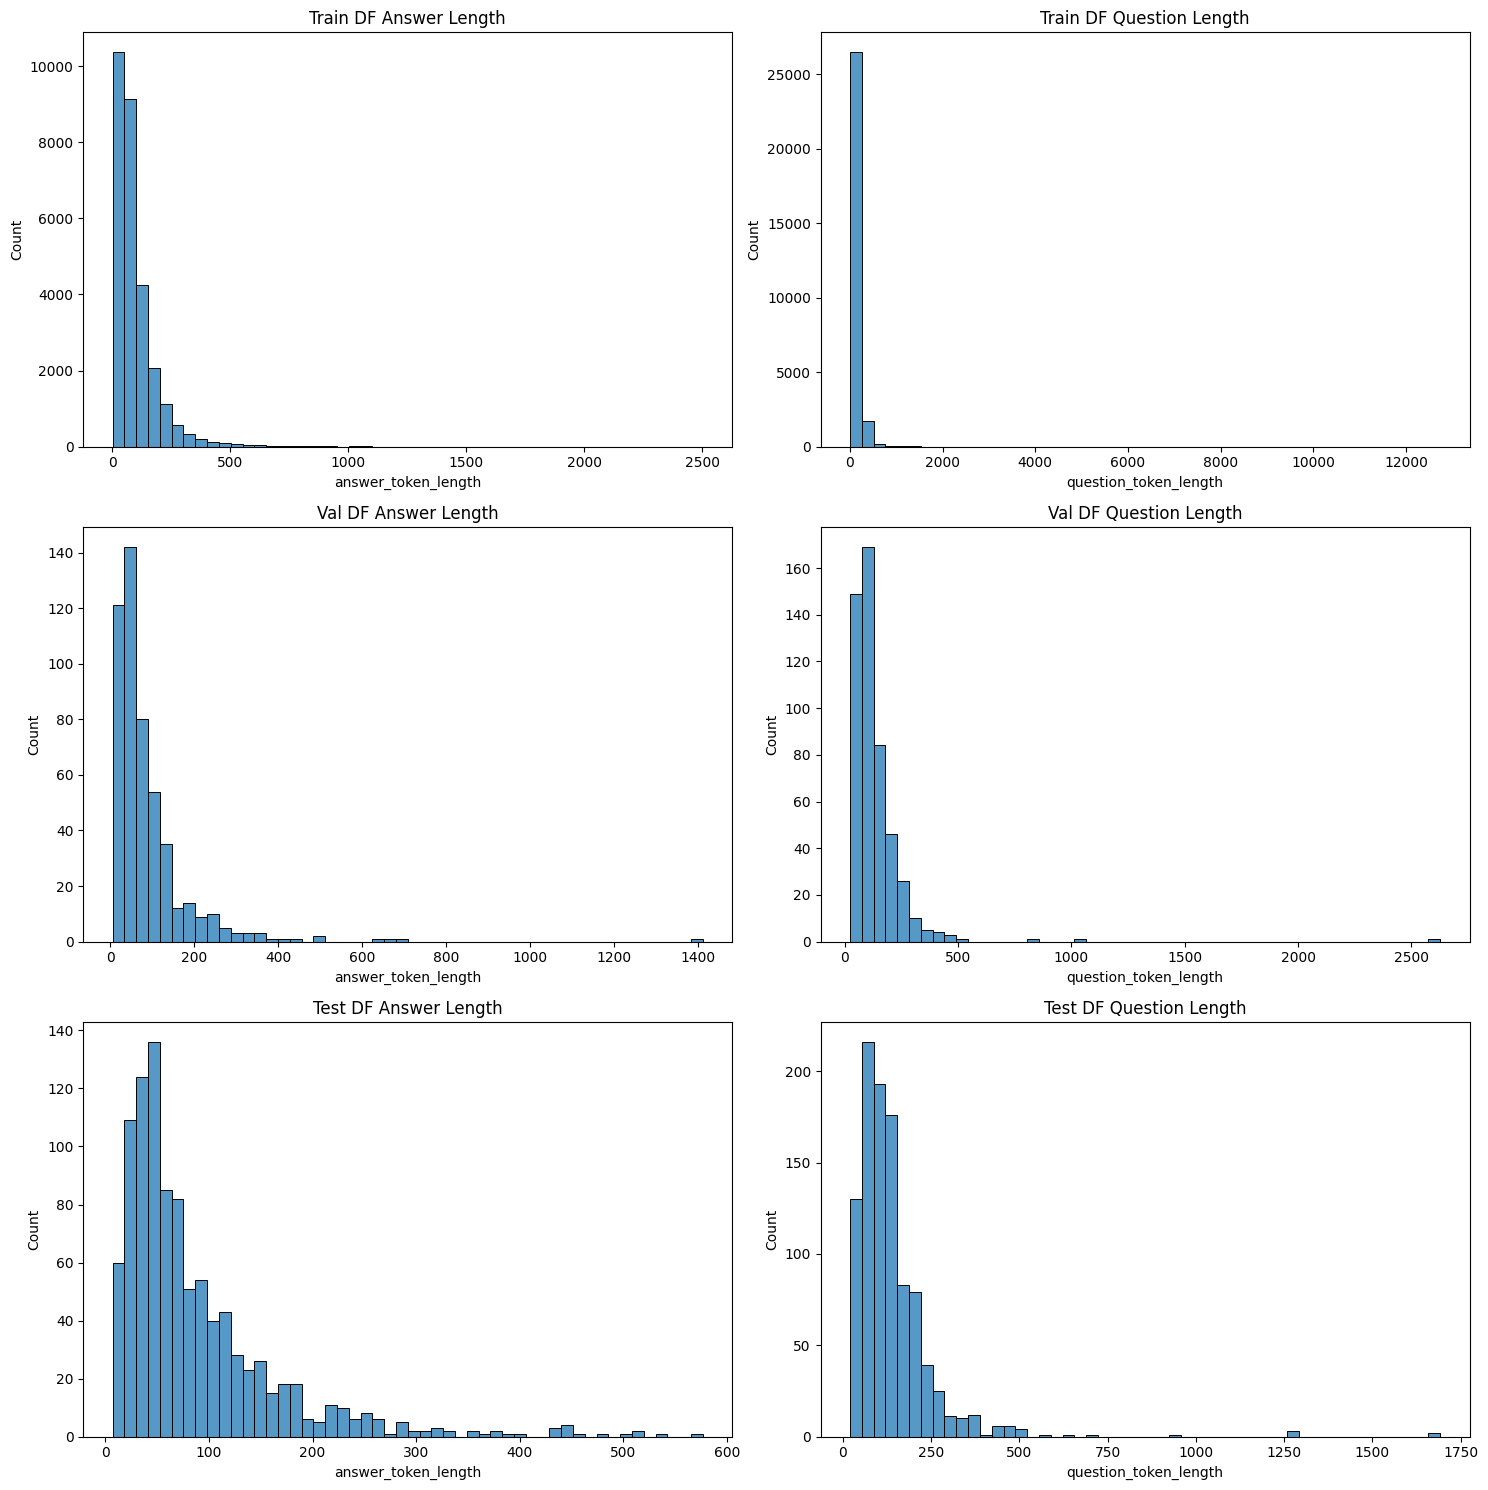

: 

In [170]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(3, 2, figsize=(15, 15))

sns.histplot(data=train_df, x="answer_token_length", ax=axs[0, 0], bins=50)
axs[0, 0].set_title('Train DF Answer Length')

sns.histplot(data=train_df, x="question_token_length", ax=axs[0, 1], bins=50)
axs[0, 1].set_title('Train DF Question Length')

sns.histplot(data=val_df, x="answer_token_length", ax=axs[1, 0], bins=50)
axs[1, 0].set_title('Val DF Answer Length')

sns.histplot(data=val_df, x="question_token_length", ax=axs[1, 1], bins=50)
axs[1, 1].set_title('Val DF Question Length')

sns.histplot(data=test_df, x="answer_token_length", ax=axs[2, 0], bins=50)
axs[2, 0].set_title('Test DF Answer Length')

sns.histplot(data=test_df, x="question_token_length", ax=axs[2, 1], bins=50)
axs[2, 1].set_title('Test DF Question Length')

plt.tight_layout()
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 3, figsize=(18, 10))

sns.distplot(train_df["Score"], ax=ax[0, 0], color='blue')
ax[0, 0].set_title('Train Score Distribution')

sns.distplot(val_df["Score"], ax=ax[0, 1], color='orange')
ax[0, 1].set_title('Validation Score Distribution')

sns.distplot(test_df["Score"], ax=ax[0, 2], color='green')
ax[0, 2].set_title('Test Score Distribution')

sns.distplot(train_df["log_score"], ax=ax[1, 0], color='blue')
ax[1, 0].set_title('Train Log Score Distribution')

sns.distplot(val_df["log_score"], ax=ax[1, 1], color='orange')
ax[1, 1].set_title('Validation Log Score Distribution')

sns.distplot(test_df["log_score"], ax=ax[1, 2], color='green')
ax[1, 2].set_title('Test Log Score Distribution')

plt.tight_layout()
plt.show()

## Pre-generation stage

In [2]:
dataset = load_dataset("Myashka/SO-Python_basics_QA-filtered-2023-tanh_score")
df = pd.concat([dataset["train"].to_pandas(), dataset["validation"].to_pandas(), dataset["test"].to_pandas()], ignore_index=True)

Found cached dataset json (/home/st-gorbatovski/.cache/huggingface/datasets/Myashka___json/Myashka--SO-Python_basics_QA-filtered-2023-tanh_score-65cea773c91b5e47/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)
100%|██████████| 3/3 [00:00<00:00, 762.97it/s]


In [4]:
df.columns

Index(['Score', 'Available Count', 'A_Id', 'CreationDate', 'AnswerCount',
       'Q_Score', 'Title', 'is_accepted', 'Answer', 'Q_Id', 'Users Score',
       'ViewCount', 'Tags', 'Question', 'log_score'],
      dtype='object')

In [40]:
df.head(2)

,Score,Available Count,A_Id,CreationDate,AnswerCount,Q_Score,Title,is_accepted,Answer,Q_Id,Users Score,ViewCount,Tags,Question,log_score
0,0.022219,14,49586164,2008-08-05T07:18:00.000,18,58,"Python: what is the difference between (1,2,3)...",False,"(1,2,3) and [1,2,3] can be used interchangeabl...",1983,2,12477,"python,list,tuples","In many places, (1,2,3) (a tuple) and [1,2,3] ...",2
1,0.022219,14,5746,2008-08-05T07:18:00.000,18,58,"Python: what is the difference between (1,2,3)...",False,If you can find a solution that works with tup...,1983,2,12477,"python,list,tuples","In many places, (1,2,3) (a tuple) and [1,2,3] ...",2


In [41]:
print(len(df[df["Available Count"] == 1]))
print(len(df[(df["Available Count"] > 1) & (df["Available Count"] < 5)]))
print(len(df[df["Available Count"] >= 5]))

17265
10302
2417


In [42]:
len(df[(df["Available Count"] == 1) & (df["log_score"] == -1)])

515

In [43]:
len(df) - len(df[df['log_score'] >= 0])

946

In [8]:
positive_df = (df[df['log_score'] >= 0])

In [9]:
q_exp_df = positive_df.groupby('Q_Id').first().reset_index()
q_exp_df.to_json("/home/st-gorbatovski/sollama/data/processed/tanh_score/python_basics/unique_q_to_gen.json", orient='records')

In [10]:
len(q_exp_df)

21480

In [45]:
print(len(positive_df[positive_df["Available Count"] == 1]))
print(len(positive_df[(positive_df["Available Count"] > 1) & (positive_df["Available Count"] < 5)]))
print(len(positive_df[positive_df["Available Count"] >= 5]))

16750
9971
2317


## Dataset building

In [1]:
from datasets import load_dataset
import pandas as pd

/home/st-gorbatovski/.conda/envs/gorbatovski_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
paraphrased_df = pd.read_csv("/home/st-gorbatovski/sollama/t5_paraphraser/SO-Python_basics_QA-filtered-2023-tanh_score_paraphrased_data.csv", lineterminator='\n')

In [8]:
gen_df = pd.read_csv(
    "/home/st-gorbatovski/sollama/src/sft/artifacts/generation/gen-LoRA_llama_no_0_scores-7b-max_prompt_length_512-t_09-basics.csv",
    lineterminator="\n",
)

In [9]:
dataset = load_dataset("Myashka/SO-Python_basics_QA-filtered-2023-tanh_score")

df = pd.concat([dataset["train"].to_pandas(), dataset["validation"].to_pandas(), dataset["test"].to_pandas()], ignore_index=True)
print(df.columns)

Found cached dataset json (/home/st-gorbatovski/.cache/huggingface/datasets/Myashka___json/Myashka--SO-Python_basics_QA-filtered-2023-tanh_score-65cea773c91b5e47/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)
100%|██████████| 3/3 [00:00<00:00, 503.54it/s]

Index(['Question', 'Answer', 'CreationDate', 'Users Score', 'Q_Id',
       'AnswerCount', 'Tags', 'Score', 'Title', 'ViewCount', 'is_accepted',
       'Available Count', 'Q_Score', 'A_Id', 'log_score'],
      dtype='object')


## Paraphrase adding

## Making pairs

In [16]:
gen_df['is_accepted'] = False
gen_df['is_generated'] = True
gen_df['is_paraphrased'] = False

paraphrased_df['is_paraphrased'] = True
paraphrased_df['is_generated'] = False

df['is_generated'] = False
df['is_paraphrased'] = False

In [18]:
paraphrased_df.columns

Index(['Question', 'Answer', 'CreationDate', 'Users Score', 'Q_Id',
       'AnswerCount', 'Tags', 'Score', 'Title', 'ViewCount', 'is_accepted',
       'Available Count', 'Q_Score', 'A_Id', 'log_score', 'Par_A_Id',
       'Paraphrased Answer', 'is_paraphrased', 'is_generated'],
      dtype='object')

In [19]:
del gen_df["Answer"], paraphrased_df["Answer"]
gen_df.rename(columns={"Generated Answer": "Answer"}, inplace=True)
paraphrased_df.rename(columns={"Paraphrased Answer": "Answer"}, inplace=True)
gen_df["Score"] = -1
gen_df["log_score"] = -1
del (
    gen_df["Users Score"],
    gen_df["Gen_Q_Id"],
    paraphrased_df["Par_A_Id"],
    paraphrased_df["Users Score"],
    paraphrased_df["Available Count"],
    paraphrased_df["A_Id"],
    paraphrased_df["AnswerCount"],
    paraphrased_df["Q_Score"],
    paraphrased_df["ViewCount"],
    paraphrased_df["Tags"],
    df["Users Score"],
    df["Available Count"],
    df["A_Id"],
    df["AnswerCount"],
    df["Q_Score"],
    df["ViewCount"],
    df["Tags"],
)

In [20]:
print(len(df))
print(len(df[df['is_accepted'] == True]))
df.head(1)

29984
6955


,Question,Answer,CreationDate,Q_Id,Score,Title,is_accepted,log_score,is_generated,is_paraphrased
0,"In many places, (1,2,3) (a tuple) and [1,2,3] ...","(1,2,3) and [1,2,3] can be used interchangeabl...",2008-08-05T07:18:00.000,1983,0.022219,"Python: what is the difference between (1,2,3)...",False,2,False,False


In [7]:
len(df)

29984

In [21]:
combined_df = pd.concat((df, gen_df, paraphrased_df), ignore_index=True).sort_values(["CreationDate", "Q_Id"]).reset_index(drop=True)

In [25]:
def binary_comparison(scores):
    """Returns tuples of responses, where the first response always has a higher score than the second."""
    pairs = []

    for i in range(len(scores) - 1):
        for j in range(i + 1, len(scores)):
            if scores[i] > scores[j]:
                pairs.append((i, j))

    return pairs


def generate_response_pairs(df):
    MAX_PAIRS_PER_QUESTION = 50

    new_data = {
        "CreationDate": [],
        "Question": [],
        "Title": [],
        "Q_Id": [],
        "response_j": [],
        "response_k": [],
        "is_gen_j": [],
        "is_gen_k": [],
        "is_par_j": [],
        "is_par_k": [],
        "log_score_j": [],
        "log_score_k": [],
    }

    for _, group in df.groupby("Q_Id"):
        scores = group["log_score"].tolist()
        if len(scores) == 1:
            continue
        pairs = binary_comparison(scores)

        # if len(pairs) > MAX_PAIRS_PER_QUESTION:
        #     indices = np.random.choice(
        #         list(range(len(pairs))), MAX_PAIRS_PER_QUESTION, replace=False
        #     )
        #     pairs = [pairs[i] for i in indices]

        for pair in pairs:
            idx_j, idx_k = pair
            new_data["Question"].append(group.iloc[0]["Question"])
            new_data["Title"].append(group.iloc[0]["Title"])
            new_data["Q_Id"].append(group.iloc[0]["Q_Id"])
            new_data["CreationDate"].append(group.iloc[0]["CreationDate"])
            new_data["response_j"].append(group.iloc[idx_j]["Answer"])
            new_data["response_k"].append(group.iloc[idx_k]["Answer"])
            new_data["is_gen_j"].append(group.iloc[idx_j]["is_generated"])
            new_data["is_gen_k"].append(group.iloc[idx_k]["is_generated"])
            new_data["is_par_j"].append(group.iloc[idx_j]["is_paraphrased"])
            new_data["is_par_k"].append(group.iloc[idx_k]["is_paraphrased"])
            new_data["log_score_j"].append(group.iloc[idx_j]["log_score"])
            new_data["log_score_k"].append(group.iloc[idx_k]["log_score"])

    return pd.DataFrame(new_data)

In [14]:
# human_preferences_df = generate_response_pairs(df)

In [26]:
paired_df = generate_response_pairs(combined_df)

In [29]:
paired_df.columns

Index(['CreationDate', 'Question', 'Title', 'Q_Id', 'response_j', 'response_k',
       'is_gen_j', 'is_gen_k', 'is_par_j', 'is_par_k', 'log_score_j',
       'log_score_k'],
      dtype='object')

In [34]:
paired_df.to_json("/home/st-gorbatovski/sollama/data/processed/tanh_score/python_basics/reward/train.json", orient="records")

In [36]:
data = load_dataset('json', data_files="/home/st-gorbatovski/sollama/data/processed/tanh_score/python_basics/reward/train.json")['train']

Found cached dataset json (/home/st-gorbatovski/.cache/huggingface/datasets/json/default-4b747ab14d149075/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)
100%|██████████| 1/1 [00:00<00:00, 192.63it/s]


In [38]:
any_dataset = data.filter(lambda x: (x["is_gen_k"] or x["is_gen_j"] or x["is_par_k"] or x["is_par_j"]))
so_dataset = data.filter(lambda x: not (x["is_gen_k"] or x["is_gen_j"] or x["is_par_k"] or x["is_par_j"]))

In [41]:
print(len(data))
print(len(any_dataset) + len(so_dataset))

185140
185140


## Paraphrasing SFT dataset

In [3]:
dataset = load_dataset("Myashka/SO-Python_basics_QA-filtered-2023-tanh_score")

df = pd.concat([dataset["train"].to_pandas(), dataset["validation"].to_pandas()], ignore_index=True)
print(df.columns)

Found cached dataset json (/home/st-gorbatovski/.cache/huggingface/datasets/Myashka___json/Myashka--SO-Python_basics_QA-filtered-2023-tanh_score-65cea773c91b5e47/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)
100%|██████████| 3/3 [00:00<00:00, 154.35it/s]

Index(['Question', 'Answer', 'CreationDate', 'Users Score', 'Q_Id',
       'AnswerCount', 'Tags', 'Score', 'Title', 'ViewCount', 'is_accepted',
       'Available Count', 'Q_Score', 'A_Id', 'log_score'],
      dtype='object')


In [7]:
test_df = dataset["test"].to_pandas()

In [4]:
paraphrased_df = pd.read_csv("/home/st-gorbatovski/sollama/t5_paraphraser/SO-Python_basics_QA-filtered-2023-tanh_score_paraphrased_data.csv", lineterminator='\n')

In [8]:
paraphrased_df['is_paraphrased'] = True
df['is_paraphrased'] = False
test_df['is_paraphrased'] = False

In [9]:
del paraphrased_df["Answer"]
paraphrased_df.rename(columns={"Paraphrased Answer": "Answer"}, inplace=True)

In [13]:
paraphrased_df = paraphrased_df[paraphrased_df["Q_Id"].isin(df['Q_Id'])]

In [19]:
del paraphrased_df["Par_A_Id"]

In [28]:
combined_df = pd.concat((df, paraphrased_df), ignore_index=True).sort_values(["CreationDate", "Q_Id"]).reset_index(drop=True)

In [30]:
grouped = combined_df.groupby('Q_Id').apply(lambda x: x)
train_df = grouped.iloc[:-500]
val_df = grouped.iloc[-500:]

/tmp/ipykernel_3844916/3886066389.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grouped = combined_df.groupby('Q_Id').apply(lambda x: x)


In [36]:
train_df.to_json('/home/st-gorbatovski/sollama/data/processed/tanh_score/python_basics/sft_paraphrased/train.json', orient='records')
val_df.to_json('/home/st-gorbatovski/sollama/data/processed/tanh_score/python_basics/sft_paraphrased/validation.json', orient='records')
test_df.to_json('/home/st-gorbatovski/sollama/data/processed/tanh_score/python_basics/sft_paraphrased/test.json', orient='records')

In [37]:
dataset = load_dataset(
    "json",
    data_files={
        "train": "/home/st-gorbatovski/sollama/data/processed/tanh_score/python_basics/sft_paraphrased/train.json",
        "validation": "/home/st-gorbatovski/sollama/data/processed/tanh_score/python_basics/sft_paraphrased/validation.json",
        "test": "/home/st-gorbatovski/sollama/data/processed/tanh_score/python_basics/sft_paraphrased/test.json",
    },
)

Extracting data files: 100%|██████████| 3/3 [00:00<00:00, 1731.99it/s]


Dataset json downloaded and prepared to /home/st-gorbatovski/.cache/huggingface/datasets/json/default-a7906e6dca24a7e3/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96. Subsequent calls will reuse this data.


100%|██████████| 3/3 [00:00<00:00, 314.38it/s]
